# Hydrological modeling with a simple LSTM network of 30 units
<p>Adaptation by D.A. Gómez-Latorre.<br>
November 26, 2025.</p>
Original Source: <a href="https://github.com/jontingvold/datascience-projects/tree/master/Hydrological%20modeling%20with%20a%20simple%20LSTM%20network%20of%2030%20units">Hydrological modeling with a simple LSTM network of 30 units</a>

In [1]:
# IMPORT FUNCTIONS 

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn.metrics

import plotly
import plotly.graph_objects

In [1]:
# Assistant: code fixed (Oct 2025)
pd.plotting.register_matplotlib_converters()

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.__version__

# Matplotlib style sheet
# Using the updated style name for seaborn-pastel
plt.style.use('seaborn-v0_8-pastel')
# Removing 'jont' as it's not a standard style
# If you need a specific style, use one from plt.style.available
%config InlineBackend.figure_format = 'retina'

In [2]:
tf.random.set_seed(13)

In [3]:
# Data preprosessing functions

def hydrological_year(df, i):
    date = df.index[i]
    if date.month >= 9:
        return date.year
    else:
        return date.year-1

In [4]:
# Tensorflow time series preprocessing functions

def multivariate_data(x, y, sequence_length, start_index=0, end_index=None, step=1):
    
    start_index = start_index + sequence_length
    if end_index is None:
        end_index = len(x) - sequence_length

    number_of_sequences = int((end_index - start_index)/step)
    number_of_features = len(x[0])

    new_x = np.zeros(shape=[number_of_sequences, sequence_length, number_of_features])
    new_y = np.zeros(shape=[number_of_sequences, sequence_length])

    for i in range(number_of_sequences):
        i_dataset = start_index + i*sequence_length
        
        slice_d = slice(i_dataset-sequence_length, i_dataset)
        if x[slice_d].shape == new_x[i].shape:
            new_x[i] = x[slice_d]
        if y[slice_d].shape == new_y[i].shape:
            new_y[i] = y[slice_d]

    return new_x, new_y

In [5]:
# Fixed ... for stateful=True

def predict(model, x_test, y_test, SEQUENCE_LENGTH, INPUT_d):
    # Resetea estados al inicio
    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()
    
    y_test_hat = y_test.copy()
    n_windows = int(len(x_test) / SEQUENCE_LENGTH)
    
    for i in range(n_windows):
        x_test_sequence = x_test.iloc[i*SEQUENCE_LENGTH:(i+1)*SEQUENCE_LENGTH]
        x_test_sequence = x_test_sequence.values.reshape([1, SEQUENCE_LENGTH, INPUT_d])
        
        # Predice (mantiene estado entre ventanas)
        y_pred = model.predict(x_test_sequence, verbose=0)
        
        # Extrae predicciones
        if len(y_pred.shape) == 3:
            y_test_hat_sequence = y_pred[0, :, :]
        else:
            y_test_hat_sequence = y_pred.reshape(-1, 1)
        
        # Asigna
        y_test_hat.iloc[i*SEQUENCE_LENGTH:(i+1)*SEQUENCE_LENGTH] = y_test_hat_sequence
    
    return y_test_hat

In [6]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title(title)
    plt.legend()
    
    plt.savefig(f'{title.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [7]:
# Result plot functions

def plot_data_with_temp_precip(x, y, y_hat, title="", init_timesteps=0):
    plt.rcParams["axes.spines.top"] = True
    plt.rcParams["axes.spines.right"] = True
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 5))
    
    year_from = y.index.year[0]
    year_to = y.index.year[-1]
    r2 = sklearn.metrics.r2_score(y.values[init_timesteps:], y_hat.values[init_timesteps:])
    
    if title:
        title = title + ", "
    if year_to == year_from+1:
        title = title + "%i/%i (R2: %.2f)" % (year_from, year_to, r2)
    else:
        title = title + "%i–%i (R2: %.2f)" % (year_from, year_to, r2)
    
    ax1 = axes[0]
    ax1.plot(y.index, y, label="Observed", linestyle="-")
    ax1.plot(y_hat.index, y_hat, label="Simulated", linestyle="-")
    ax1.set_xlabel("")
    ax1.set_ylabel("Flow (m3/s)")
    ax1.set_title(title)
    ax1.set_xlim(y.index[0], y.index[-1])
    ax1.set_ylim(ax1.get_ylim()[0], 1.3*ax1.get_ylim()[1])

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:4]
    #colors = getattr(getattr(pd.plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=4)
    
    # Nedbør
    precipitation = x[x.columns[0]]
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('axes', 1.0))
    ax2.bar(precipitation.index, precipitation, label="Precipitation (mm)", color=colors[2], width=0.8)
    ax2.set_ylabel("Precipitation (mm)")
    ax2.invert_yaxis()
    ax2.set_ylim(2.0*ax2.get_ylim()[0], ax2.get_ylim()[1])
    
    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper left", framealpha=0.5)
    
    # Temperatur
    temp = x[x.columns[1]]
    ax3 = axes[1]
    #ax3.plot(temp.index, temp, color=colors[3])
    temp.plot(ax=ax3, color=colors[3])
    ax3.set_xlabel("")
    ax3.set_ylabel("Temperature (°C)")
    ax3.axhline(0.0, color="black", linestyle="dotted")
    
    fig.tight_layout()
    
    return fig


def plot_data(y_val, y_val_hat, title=""):
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.right"] = False
    ax = pd.DataFrame({
        "Observed": y_val,
        "Simulated": y_val_hat
    }).plot(style=["-", "-"], figsize=(15, 5));
    ax.set_xlabel("")
    ax.set_ylabel("Flow (m3/s)")
    ax.set_title(title)
    ax.legend(loc="upper right")
    ax.get_figure().tight_layout()
    
    return ax
    
def plot_accumulated(y_val, y_val_hat, title=""):
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.right"] = False
    
    # Convierte a valores numpy para evitar problemas
    y_val_values = y_val.values.flatten() if isinstance(y_val, pd.DataFrame) else y_val.values
    y_val_hat_values = y_val_hat.values.flatten() if isinstance(y_val_hat, pd.DataFrame) else y_val_hat.values
    
    max_observed = y_val_values.sum()
    
    ax = pd.DataFrame({
        "Observed": pd.Series(y_val_values.cumsum(), index=y_val.index) / max_observed,
        "Simulated": pd.Series(y_val_hat_values.cumsum(), index=y_val_hat.index) / max_observed
    }).plot(style=["-", "-"], figsize=(15, 3))
    
    ax.set_xlabel("")
    ax.set_ylabel("Accumulated flow\n1.0=total observed")
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.get_figure().tight_layout()
    
    return ax

## Preprocessing 

In [8]:
# Load dataset

filename = "data/Hyd35117010_input.txt"
df = pd.read_csv(filename, sep="\t")
df = df[1:] # Drop first row
df.index = pd.to_datetime(df["Dato"] + " " + df["Time"], format='%d.%m.%Y %H:%M:%S')

df = df.drop(columns=["Dato", "Time"])

# min/max temp is equal in this dataset, so drop one and rename other
df = df.rename(columns={"T_maxC": "T_C"}).drop(columns=["T_minC"])
df = df.astype("float")

# Add hydrological years
df["hydrological_year_from"] = [hydrological_year(df, i) for i in range(len(df))]
df["hydrological_year_to"] = [hydrological_year(df, i)+1 for i in range(len(df))]
df

,P_mm,T_C,F_MetaRiverStation,hydrological_year_from,hydrological_year_to
2000-04-01,0.139,26.173,743.0,1999,2000
2000-04-02,2.867,26.253,660.0,1999,2000
2000-04-03,15.641,23.652,562.0,1999,2000
2000-04-04,4.042,24.134,526.0,1999,2000
2000-04-05,4.777,24.073,684.0,1999,2000
...,...,...,...,...,...
2015-12-27,0.000,26.620,534.2,2015,2016
2015-12-28,0.000,26.179,506.4,2015,2016
2015-12-29,0.000,25.700,504.5,2015,2016
2015-12-30,0.355,25.025,500.0,2015,2016


In [9]:
train_from_hyd_year = 2000
train_to_hyd_year = 2010
test_from_hyd_year = 2011
test_to_hyd_year = 2013

X_columns = ["P_mm", "T_C"]
Y_columns = "F_MetaRiverStation"

df_not_feb_29 = df[~((df.index.month == 2) & (df.index.day == 29))]
df_train = df_not_feb_29[(train_from_hyd_year <= df_not_feb_29["hydrological_year_from"]) & (df_not_feb_29["hydrological_year_from"] <= train_to_hyd_year)]
df_test = df_not_feb_29[(test_from_hyd_year <= df_not_feb_29["hydrological_year_from"]) & (df_not_feb_29["hydrological_year_from"] <= test_to_hyd_year)]

X_train, Y_train = df_train[X_columns], df_train[Y_columns]
X_test, Y_test = df_test[X_columns], df_test[Y_columns]

In [10]:
Y_max = df[Y_columns].max()
print("Y max: %.2f" % (Y_max,))

def normalizeY(Y):
    return  Y/Y_max

def denormalizeY(normalized_Y):
    return normalized_Y * Y_max

Y_train = normalizeY(Y_train)
Y_test = normalizeY(Y_test)

Y max: 4697.00


In [11]:
X_max = df[X_columns].max()
print("X max:\n %s" % (X_max,))

def normalizeX(X):
    return  X/X_max

def denormalizeX(normalized_X):
    return normalized_X * X_max

X_train = normalizeX(X_train)
X_test = normalizeX(X_test)

X max:
 P_mm    90.870
T_C     31.552
dtype: float64


In [12]:
# Variance
print("Variance training set: %.5f" % Y_train.var())
print("Variance validation set: %.5f" % Y_test.var())

Variance training set: 0.05063
Variance validation set: 0.04692


## Prepair dataset for Tensorflow

In [13]:
SEQUENCE_LENGTH = 30 # days
BATCH_SIZE = 1
STEP = 30
INPUT_d = 2
OUTPUT_d = 1

x_train, y_train = multivariate_data(
    X_train.values, Y_train.values, SEQUENCE_LENGTH, start_index=0, end_index=None, step=STEP)
x_val, y_val = multivariate_data(
    X_test.values, Y_test.values, SEQUENCE_LENGTH, start_index=0, end_index=None, step=STEP)

# Expand the last dimension of and to match OUTPUT_d
y_train = np.expand_dims(y_train, axis=-1)  # De (131, 30) a (131, 30, 1)
y_val = np.expand_dims(y_val, axis=-1)      # De (34, 30) a (34, 30, 1)

print("x_train shape:", x_train.shape)  # (131, 30, 2)
print("y_train shape:", y_train.shape)  # (131, 30, 1)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE, drop_remainder=True)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE, drop_remainder=True)

# Verify
for x_batch, y_batch in train_data.take(1):
    print("\nAfter batch:")
    print("X batch shape:", x_batch.shape)  # Debe ser (1, 30, 2)
    print("Y batch shape:", y_batch.shape)  # Debe ser (1, 30, 1)

x_train shape: (131, 30, 2)
y_train shape: (131, 30, 1)

After batch:
X batch shape: (1, 30, 2)
Y batch shape: (1, 30, 1)


2025-12-01 13:02:39.887084: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
###### Annual lenght
SEQUENCE_LENGTH = 365 # days
BATCH_SIZE = 1
STEP = 365

INPUT_d = 2
OUTPUT_d = 1

x_train, y_train = multivariate_data(
    X_train.values, Y_train.values, SEQUENCE_LENGTH, start_index=0, end_index=None, step=STEP)
x_val, y_val = multivariate_data(
    X_test.values, Y_test.values, SEQUENCE_LENGTH, start_index=0, end_index=None, step=STEP)

train_data2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
val_data2 = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

print(x_train.shape, y_train.shape)
print(train_data)

(9, 365, 2) (9, 365)
<_BatchDataset element_spec=(TensorSpec(shape=(1, 30, 2), dtype=tf.float64, name=None), TensorSpec(shape=(1, 30, 1), dtype=tf.float64, name=None))>


# Model

In [15]:
# Assitant fixed

klayers = tf.keras.layers

model = tf.keras.models.Sequential()

# Define el input con batch_size fijo
model.add(klayers.Input(batch_shape=(BATCH_SIZE, None, INPUT_d)))

# LSTM stateful SIN batch_input_shape
model.add(klayers.LSTM(30, return_sequences=True, stateful=True))
model.add(klayers.Dense(OUTPUT_d, activation="relu"))

model.compile(optimizer=tf.keras.optimizers.Adam(0.00003), loss='mse', metrics=['mae'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (1, None, 30)          │         3,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, None, 1)           │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,991 (15.59 KB)

 Trainable params: 3,991 (15.59 KB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
#model.load_weights('3 - LSTM statefull')

In [17]:
# Define callbacks

class ResetStateBetweenEpochs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Reset states for all layers with states
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states'):
                layer.reset_states()

class ResetStateBetweenBatches(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
       self.model.layers[0].reset_states()

# Stop after 20 epochs with no improvement
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [18]:
history = model.fit(
    train_data, 
    validation_data=val_data, 
    epochs=2000, 
    callbacks=[ResetStateBetweenEpochs(), earlyStopping]
)

Epoch 1/2000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0872 - mae: 0.2313 - val_loss: 0.0547 - val_mae: 0.1910
Epoch 2/2000
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0645 - mae: 0.2074 - val_loss: 0.0469 - val_mae: 0.1804
Epoch 3/2000
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0581 - mae: 0.2008 - val_loss: 0.0455 - val_mae: 0.1792
Epoch 4/2000
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0561 - mae: 0.1989 - val_loss: 0.0452 - val_mae: 0.1791
Epoch 5/2000
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0551 - mae: 0.1977 - val_loss: 0.0448 - val_mae: 0.1784
Epoch 6/2000
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0543 - mae: 0.1964 - val_loss: 0.0442 - val_mae: 0.1774
Epoch 7/2000
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0535 - mae: 0.1950 - val_loss: 0.0436 - val_mae: 0.1761
Epoch 8/2000
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0527 - mae: 0.1936 - val_loss: 0.0429 - val_mae: 0.1748
Epoch 9/2000
131/131 ━━━━━━━━━━━━━━━━━━━

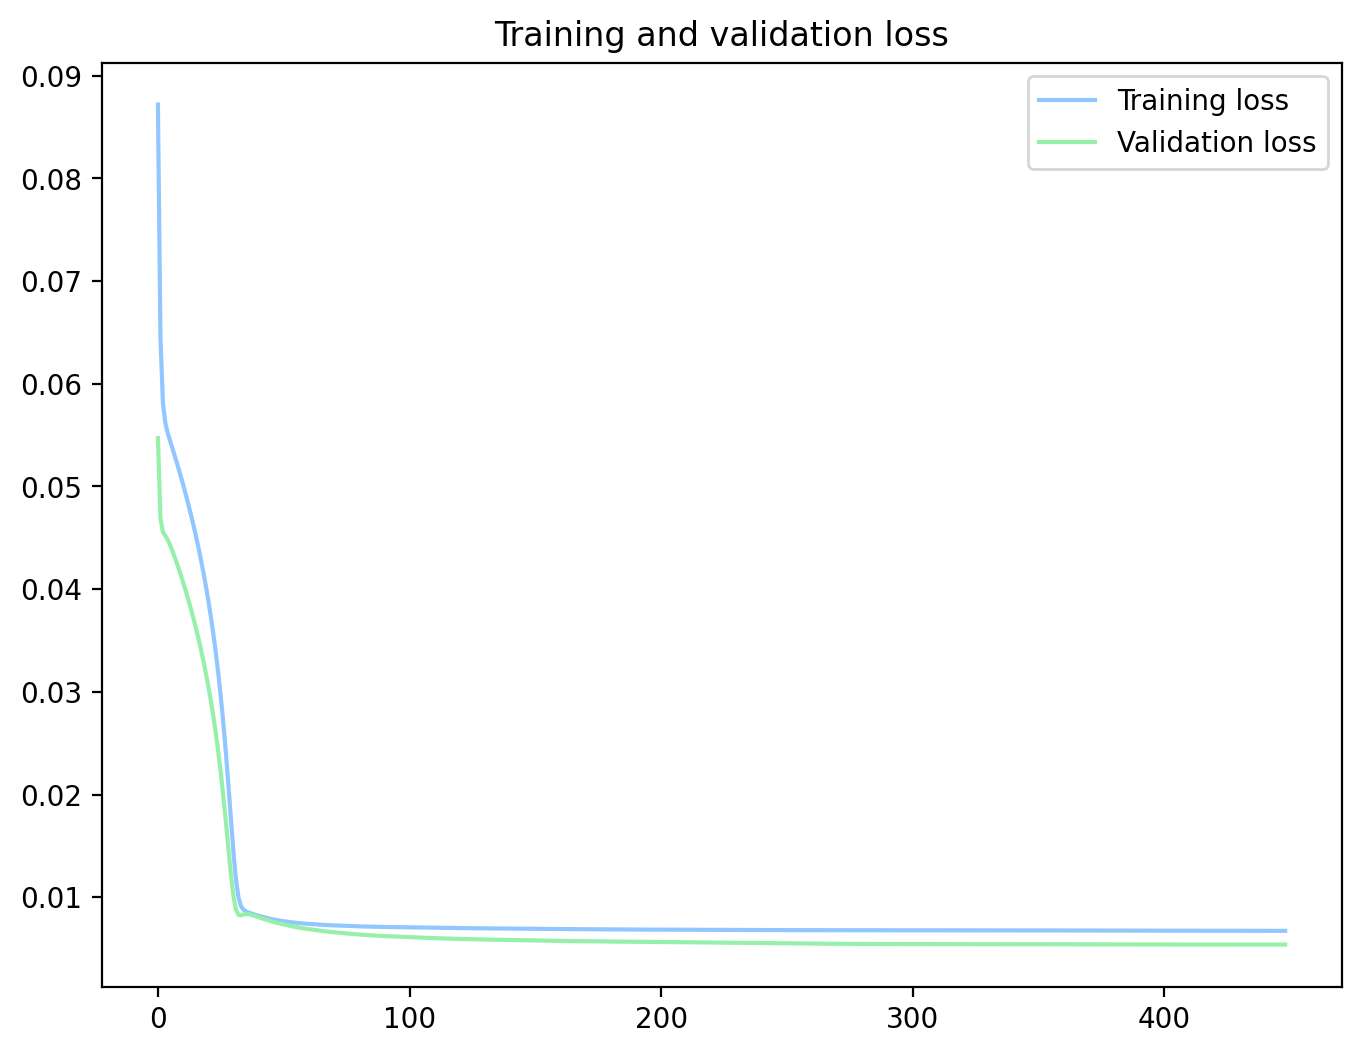

In [19]:
plot_train_history(history, 'Training and validation loss')

# Results 

## Training set

R2: 0.87 of 1.0
MAE: 287.17 m3/s


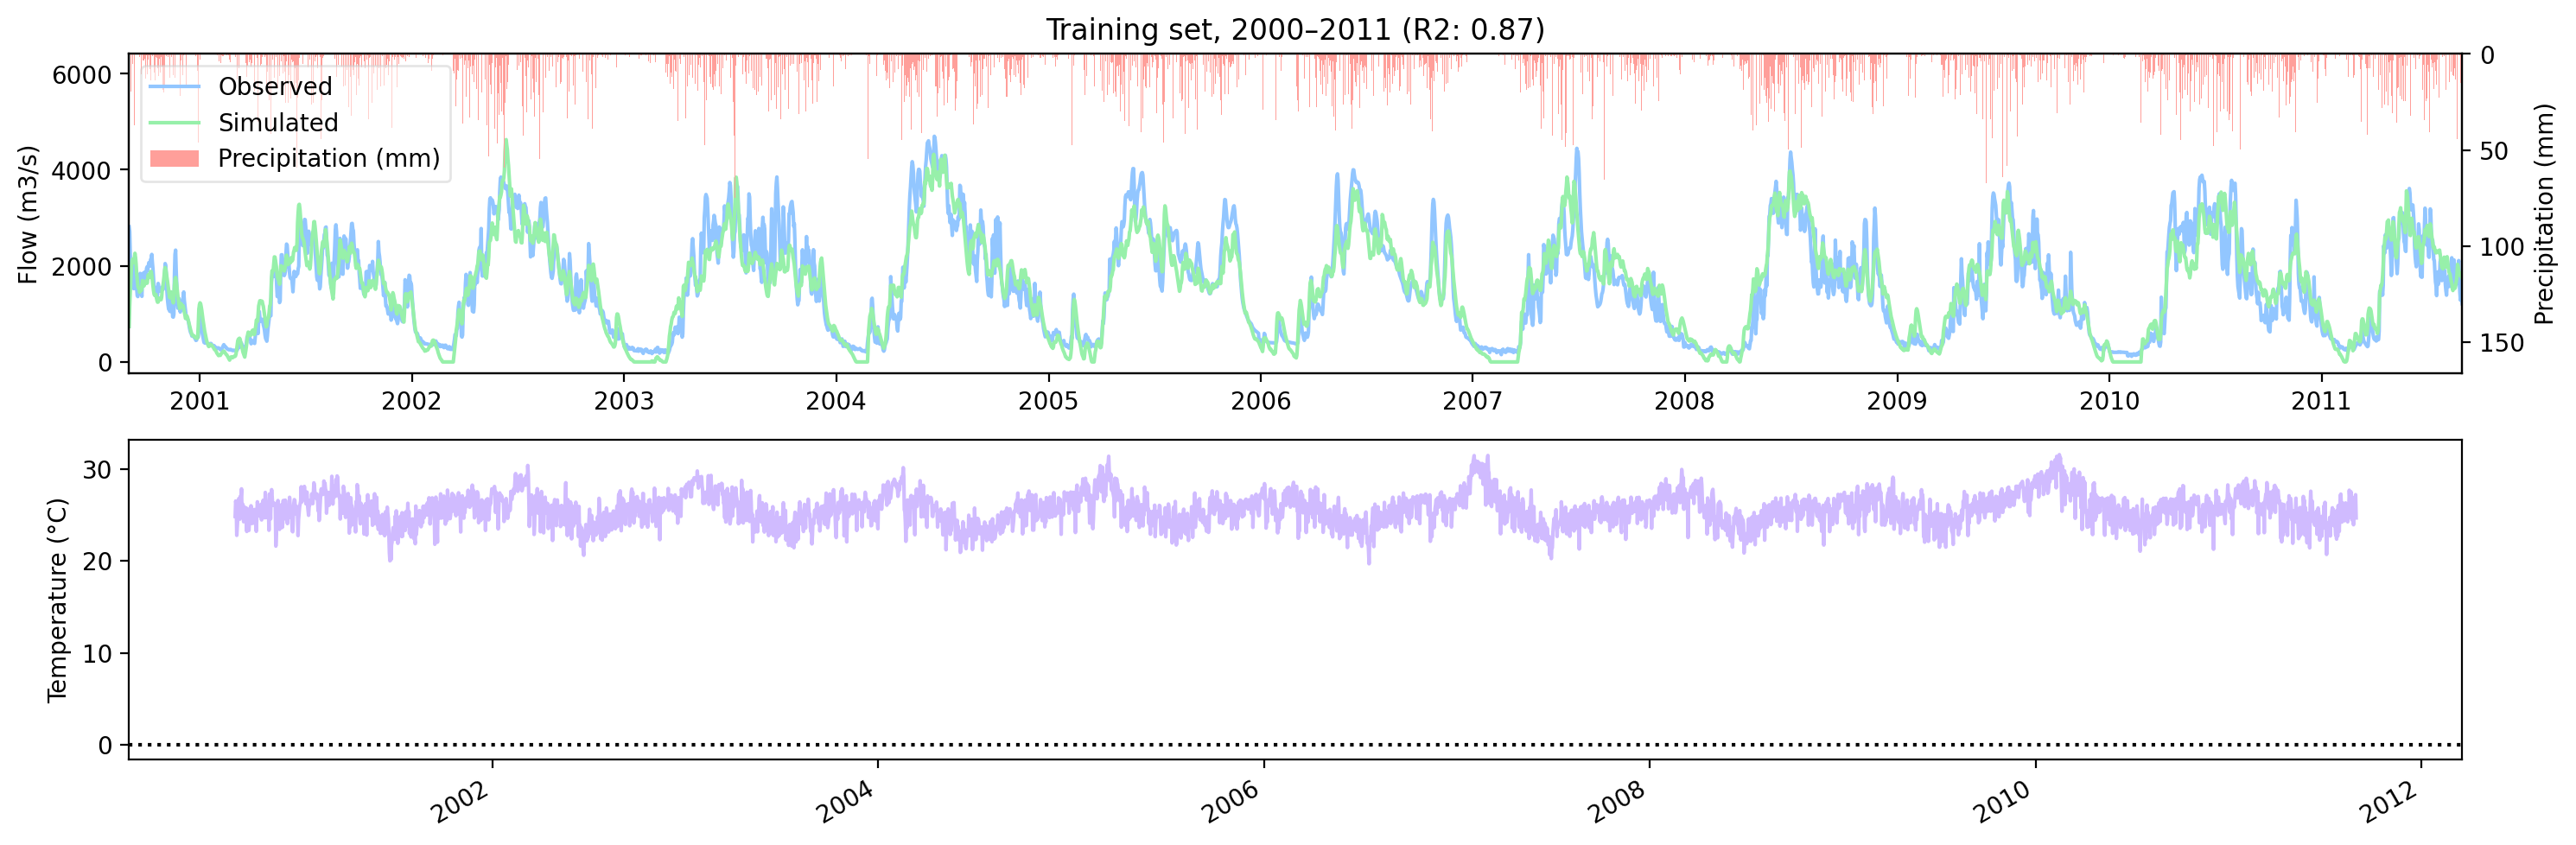

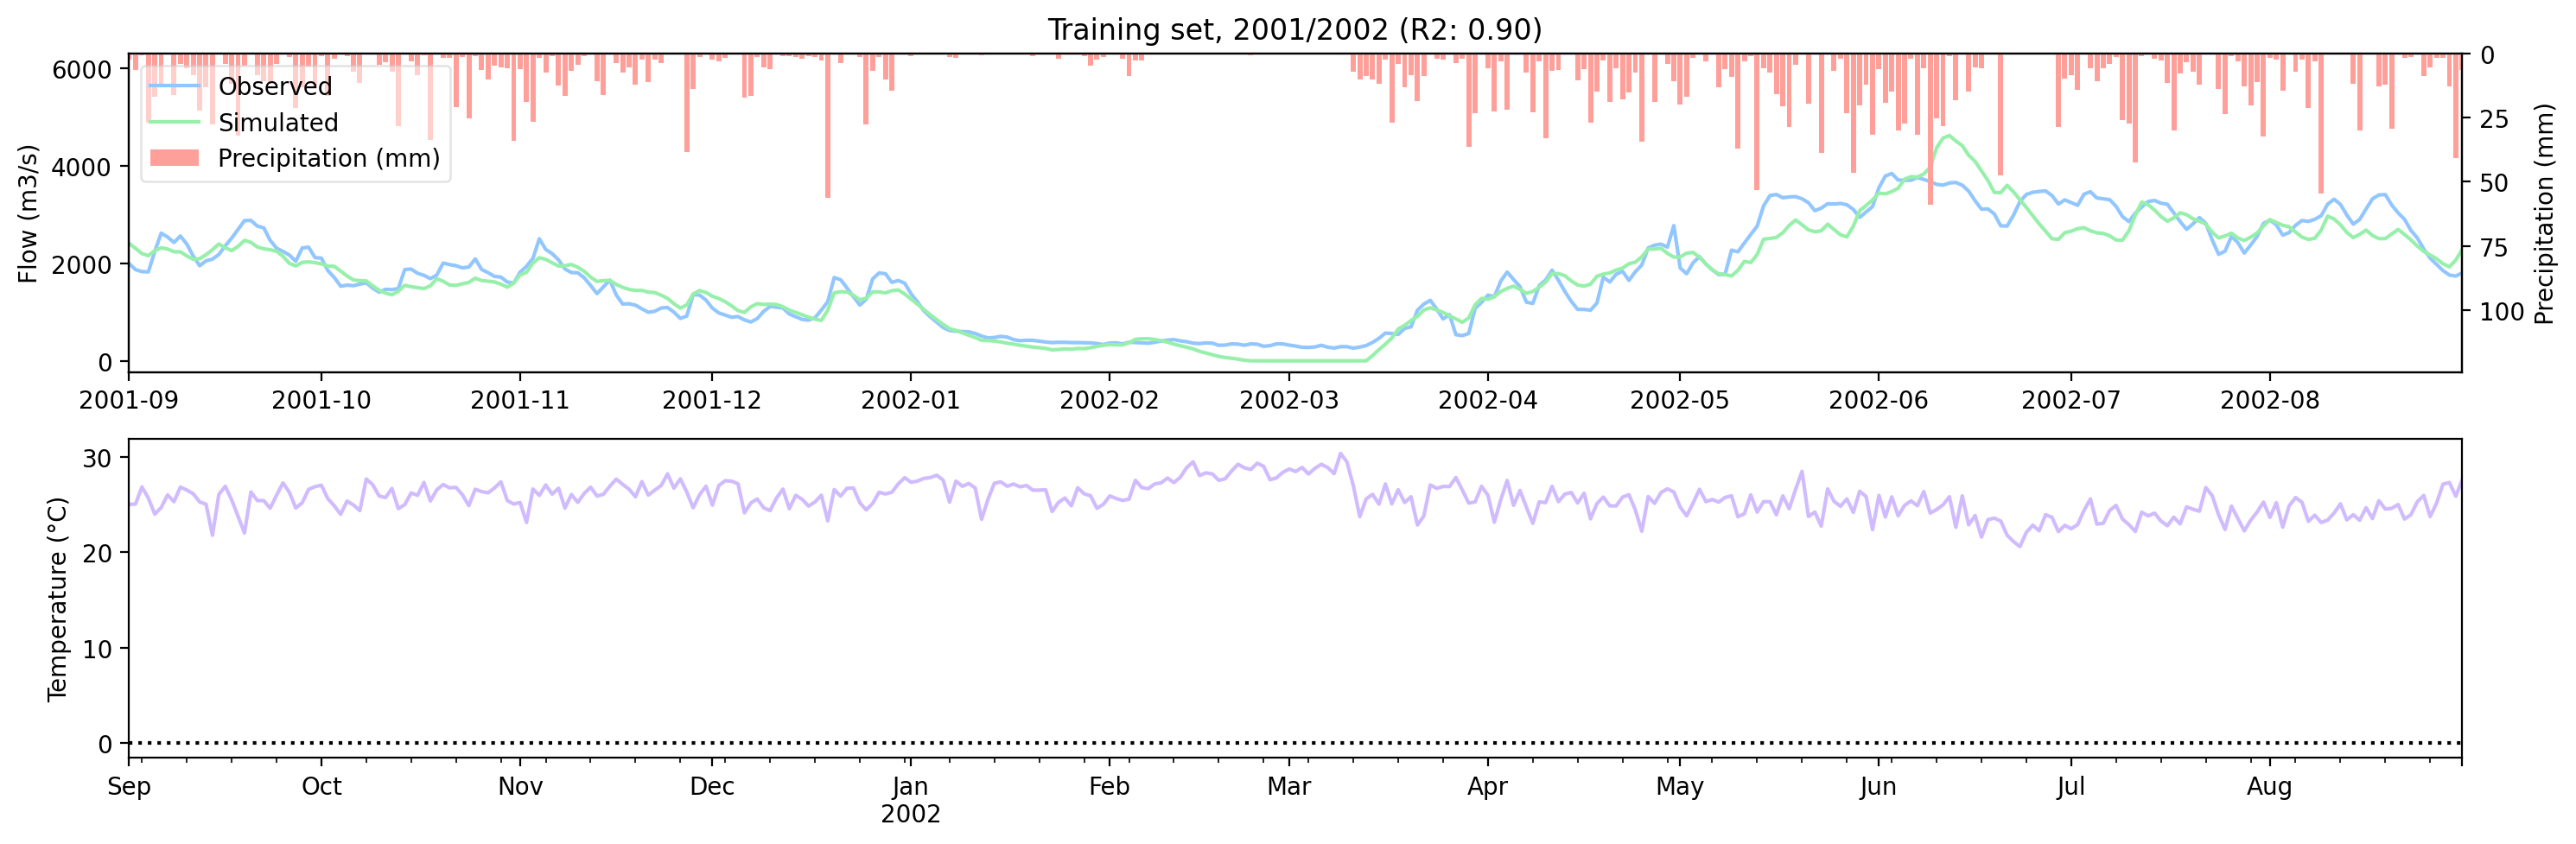

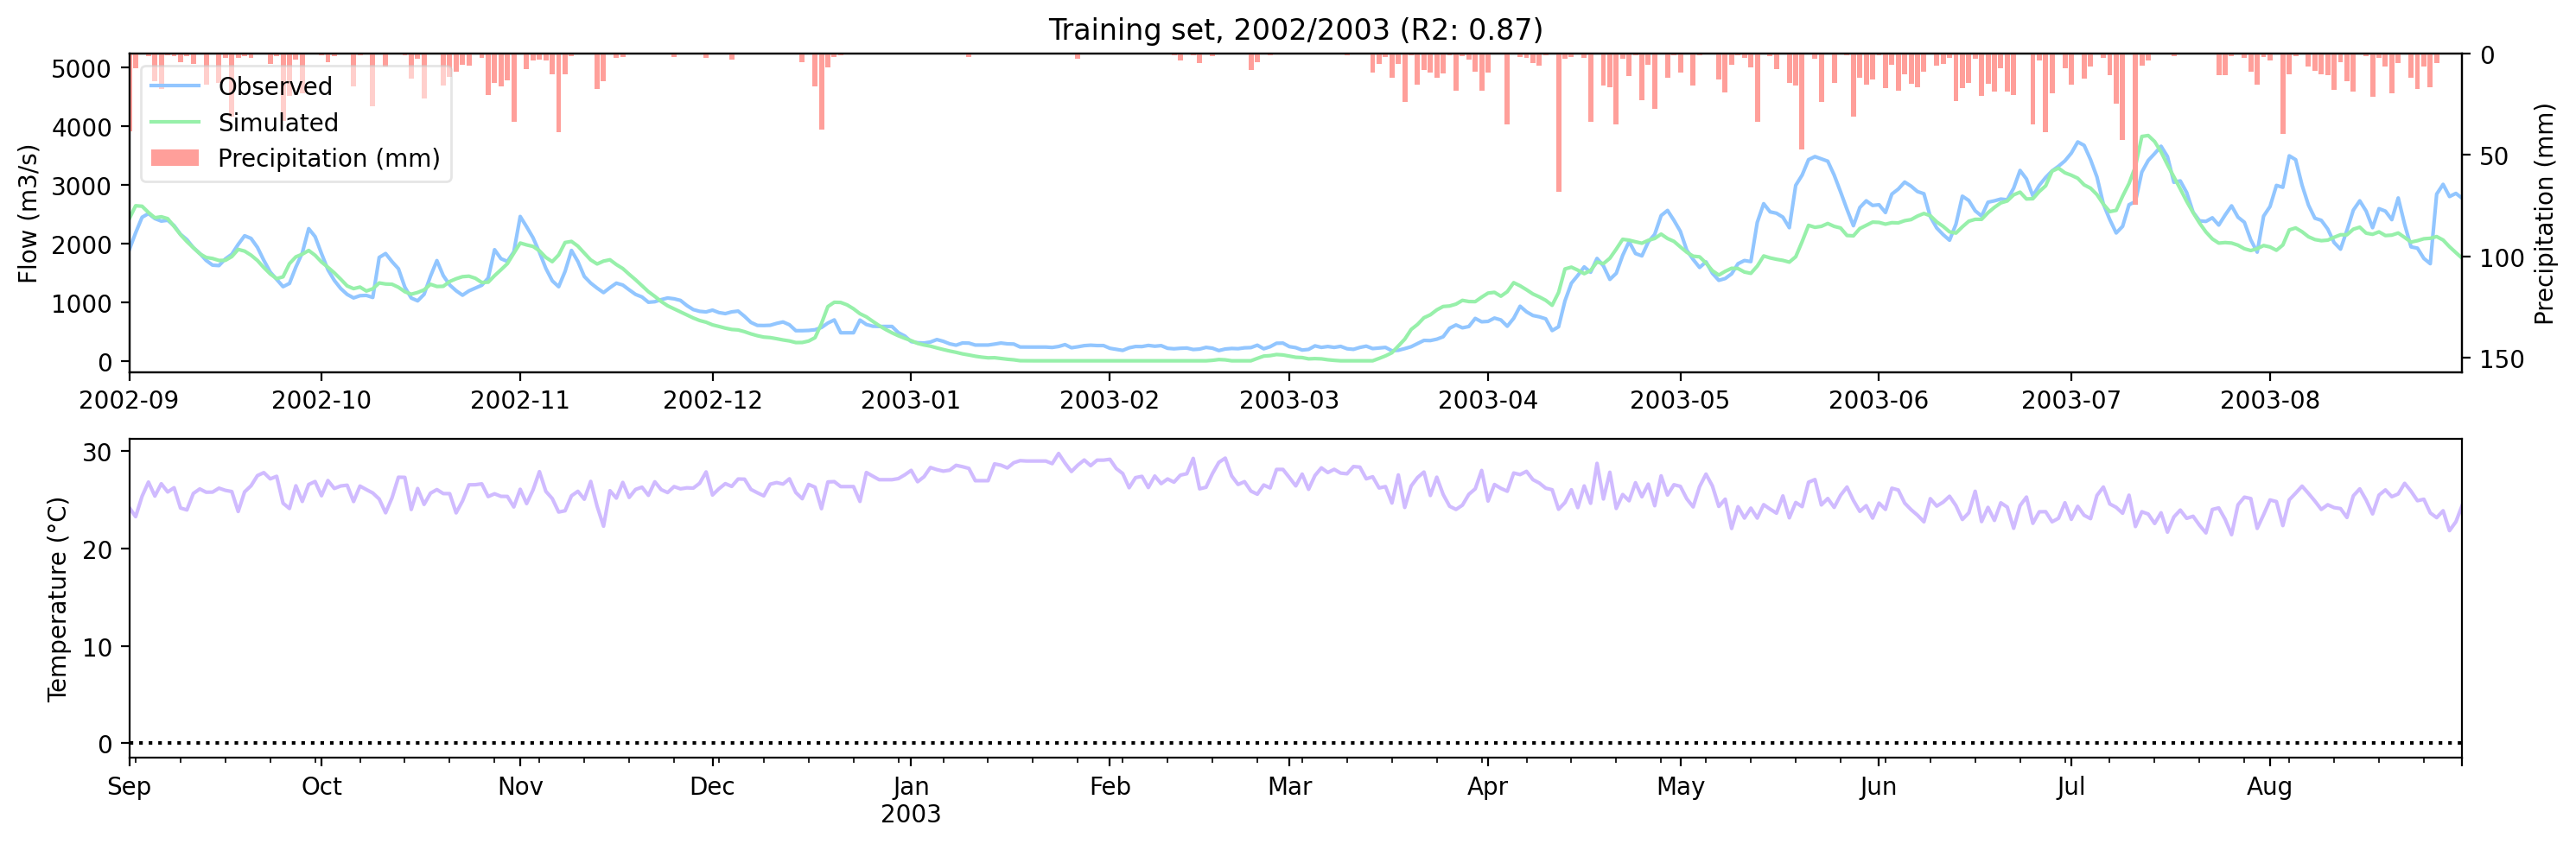

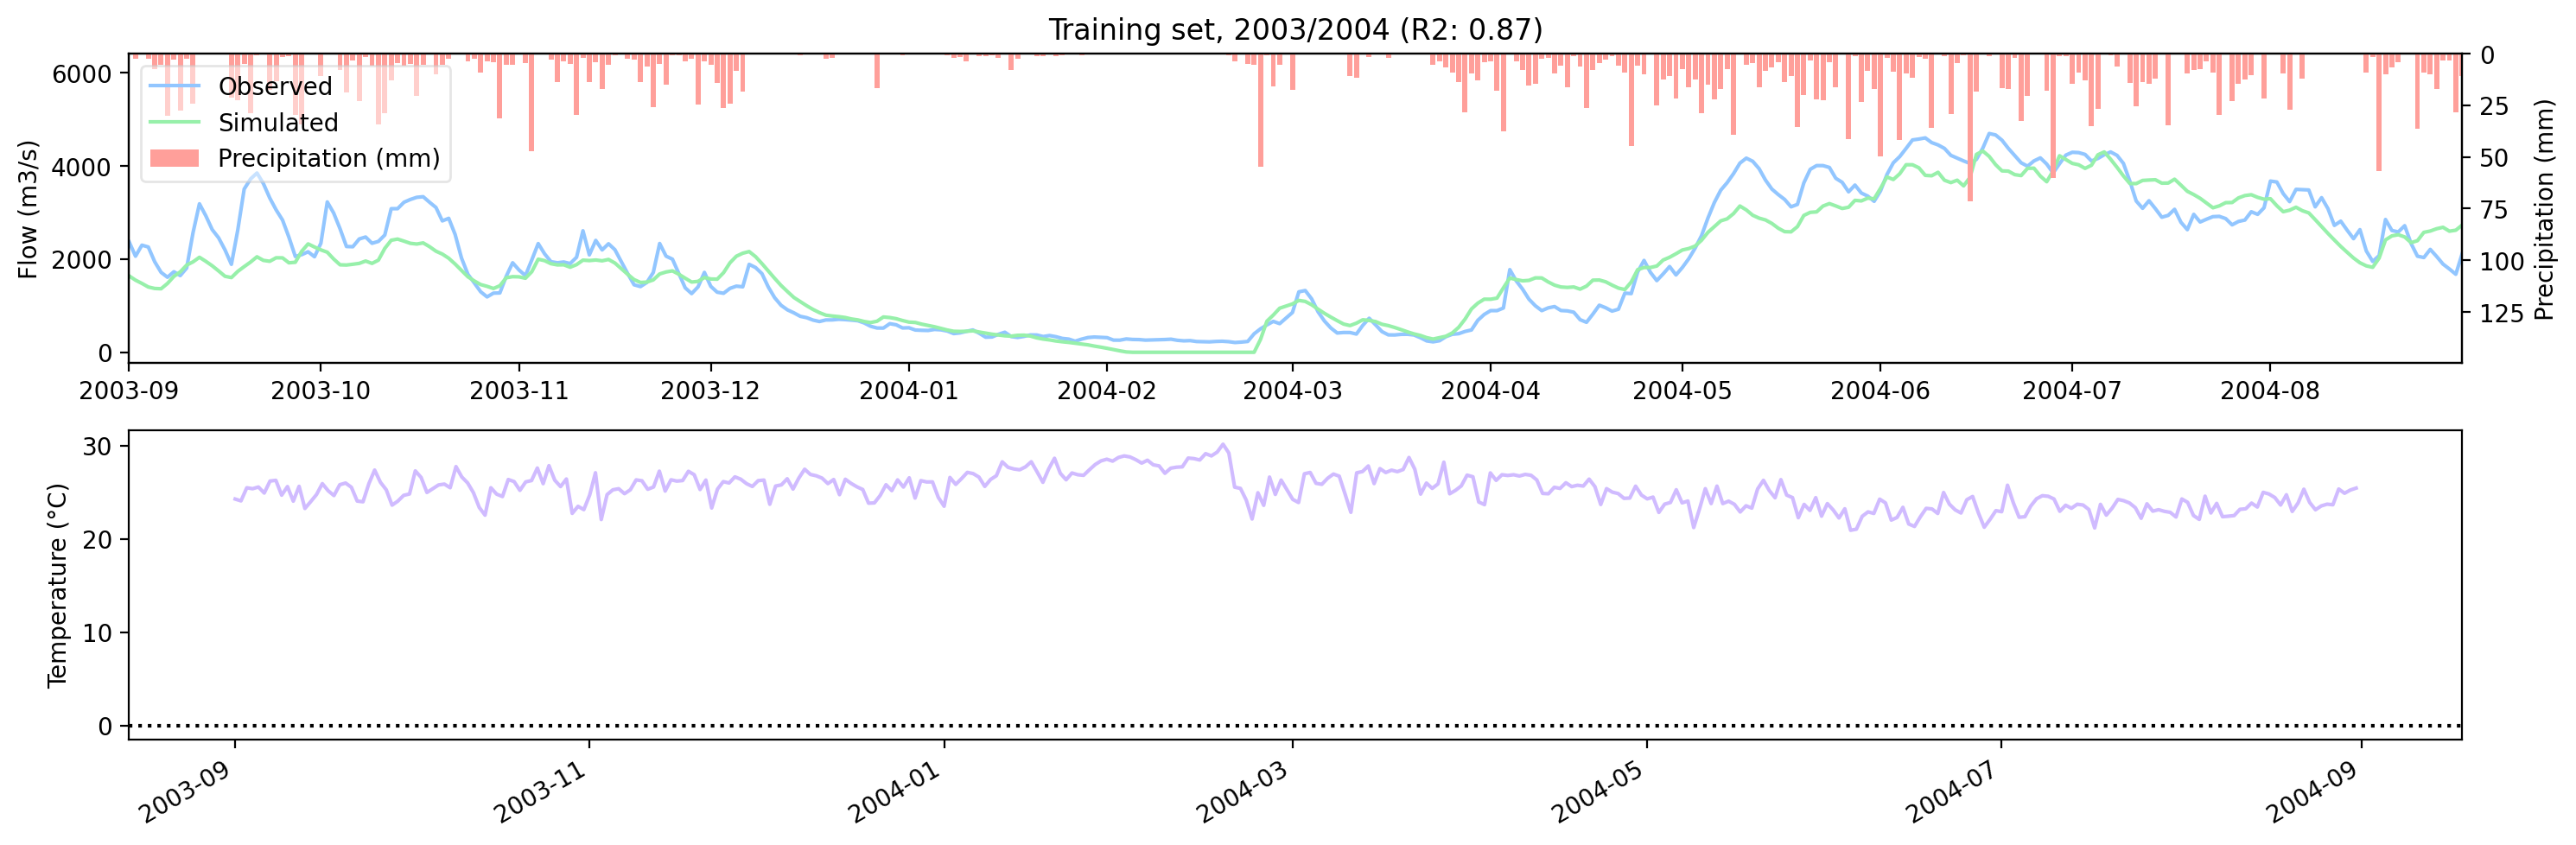

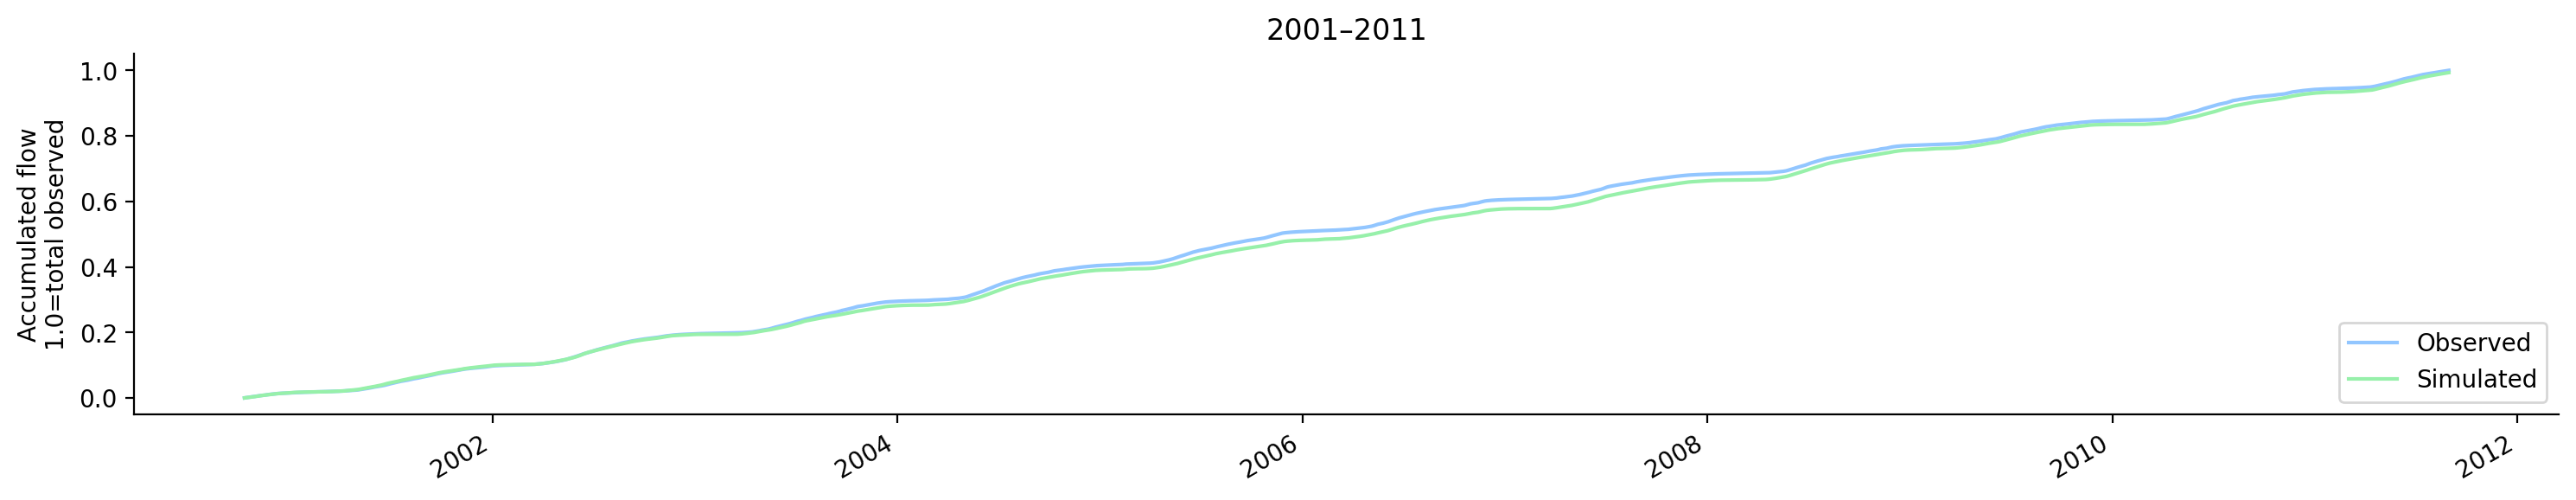

In [20]:
x = df_train[X_columns]
y = df_train[[Y_columns]]
x_norm = normalizeX(x)
y_norm = normalizeY(y)
y_hat_norm = predict(model, x_norm, y_norm, SEQUENCE_LENGTH, INPUT_d)
y_hat = denormalizeY(y_hat_norm)

init_timesteps=40
print("R2: %.2f of 1.0" % sklearn.metrics.r2_score(y.values[init_timesteps:], y_hat.values[init_timesteps:]))
print("MAE: %.2f m3/s" % sklearn.metrics.mean_absolute_error(y.values[init_timesteps:], y_hat.values[init_timesteps:]))

plot_data_with_temp_precip(x, y, y_hat, title="Training set", init_timesteps=init_timesteps);
plt.savefig(f'./results/fig_0_training_set.png', dpi=300, bbox_inches='tight')

for year in range(2001,2004):
    s = df_train.hydrological_year_from == year
    if year==2001:
        init_timesteps=40
    else:
        init_timesteps=0
    plot_data_with_temp_precip(x[s], y[s], y_hat[s], title="Training set", init_timesteps=init_timesteps);
    plt.savefig(f'./results/fig_training_year_{year}.png', dpi=300, bbox_inches='tight')

init_timesteps=40
plot_accumulated(y[init_timesteps:], y_hat[init_timesteps:], title="%i–%i" % (2001, 2011));
plt.savefig('./results/fig_accumulated_training.png', dpi=300, bbox_inches='tight')

## Validation set

R2: 0.85 of 1.0
MAE: 289.56 m3/s


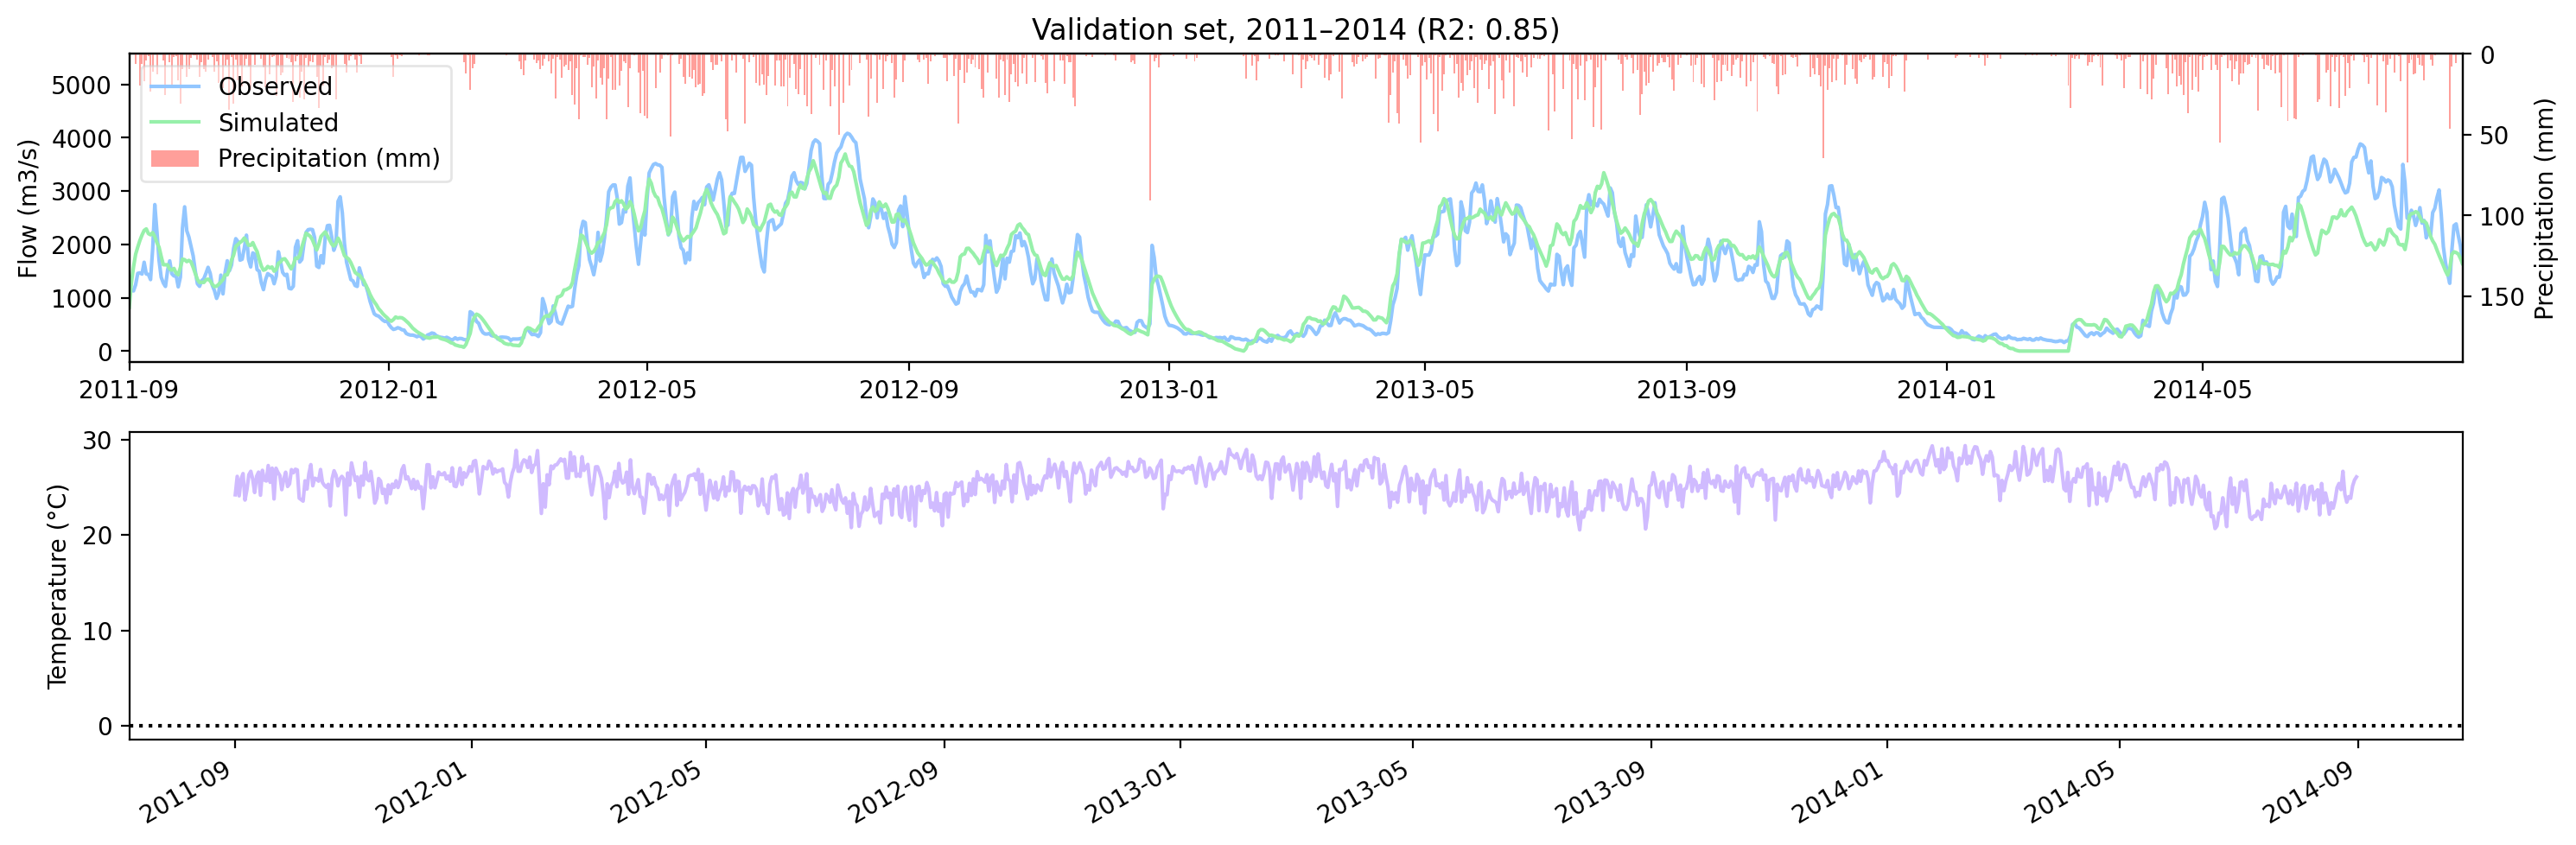

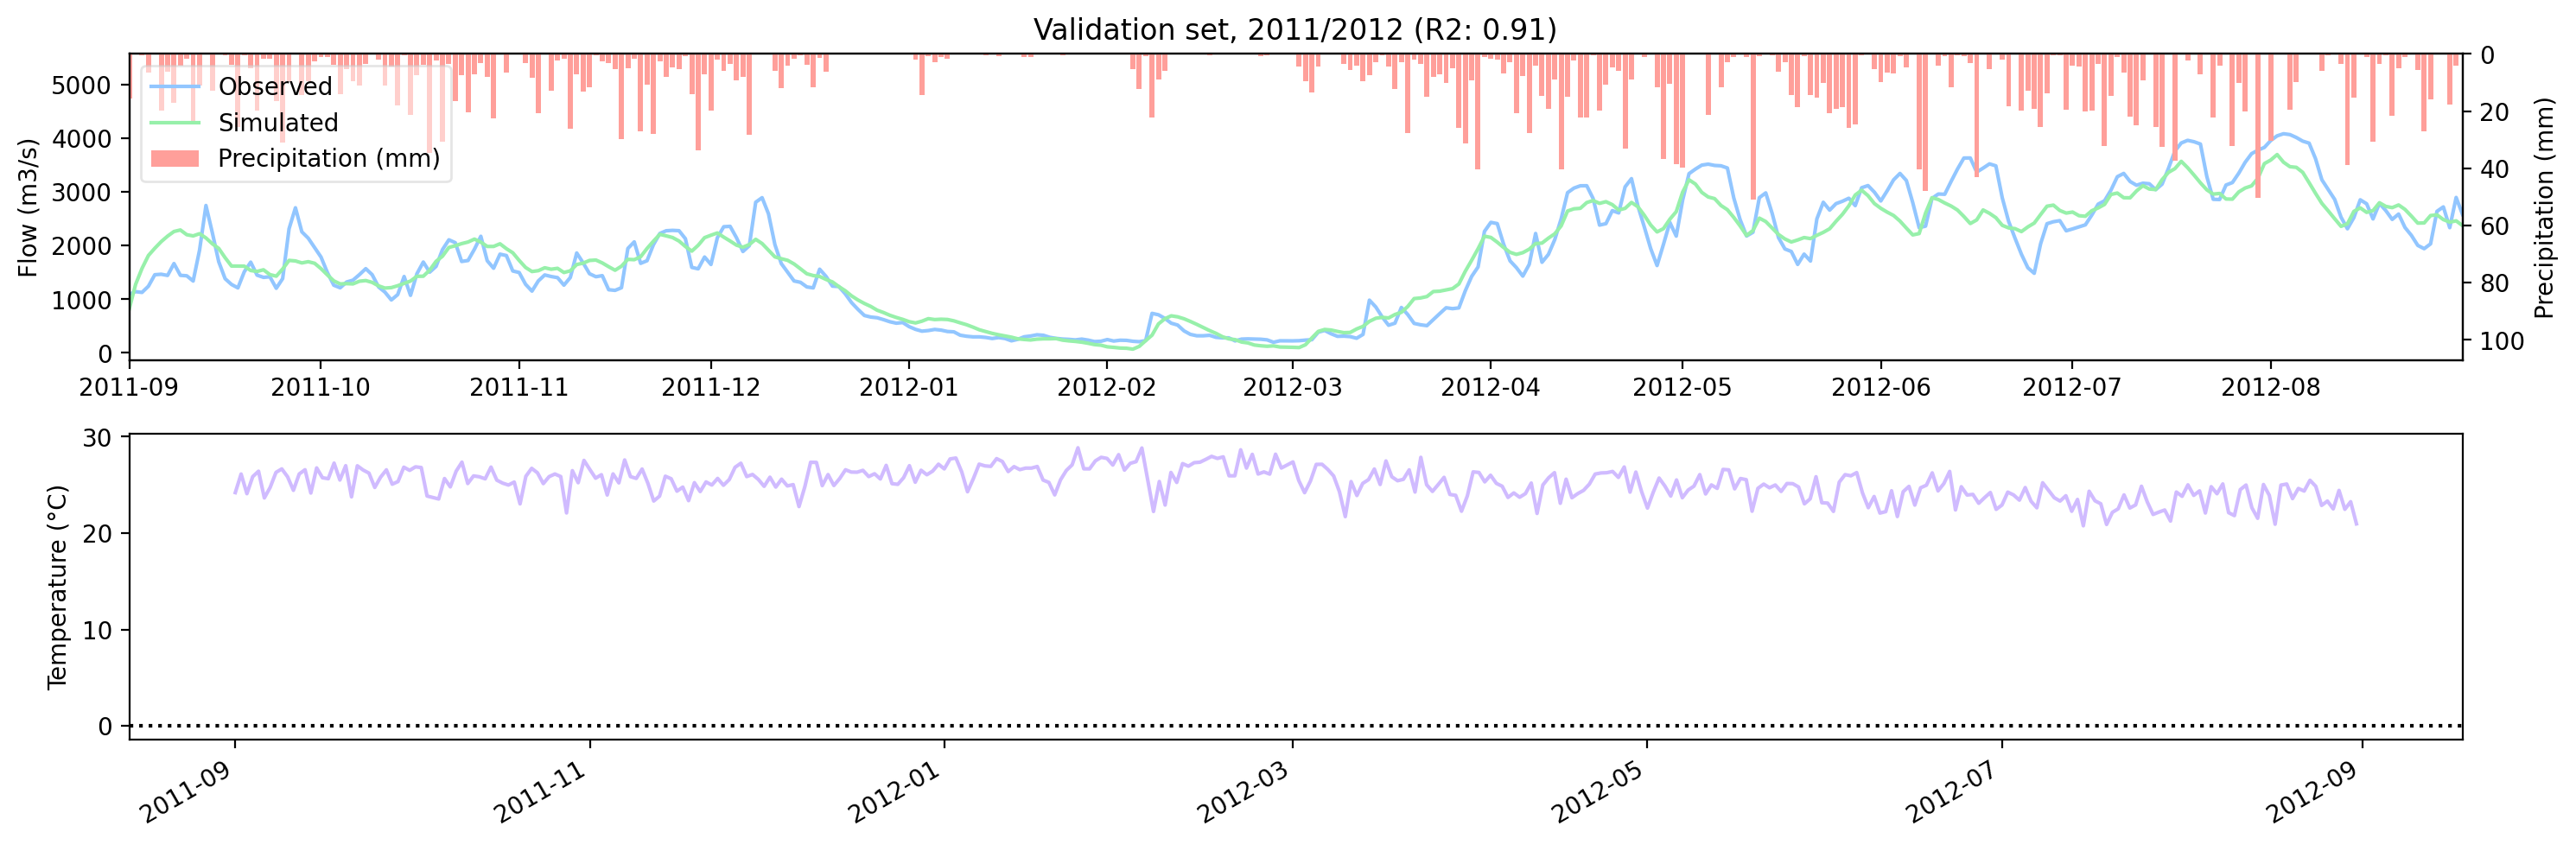

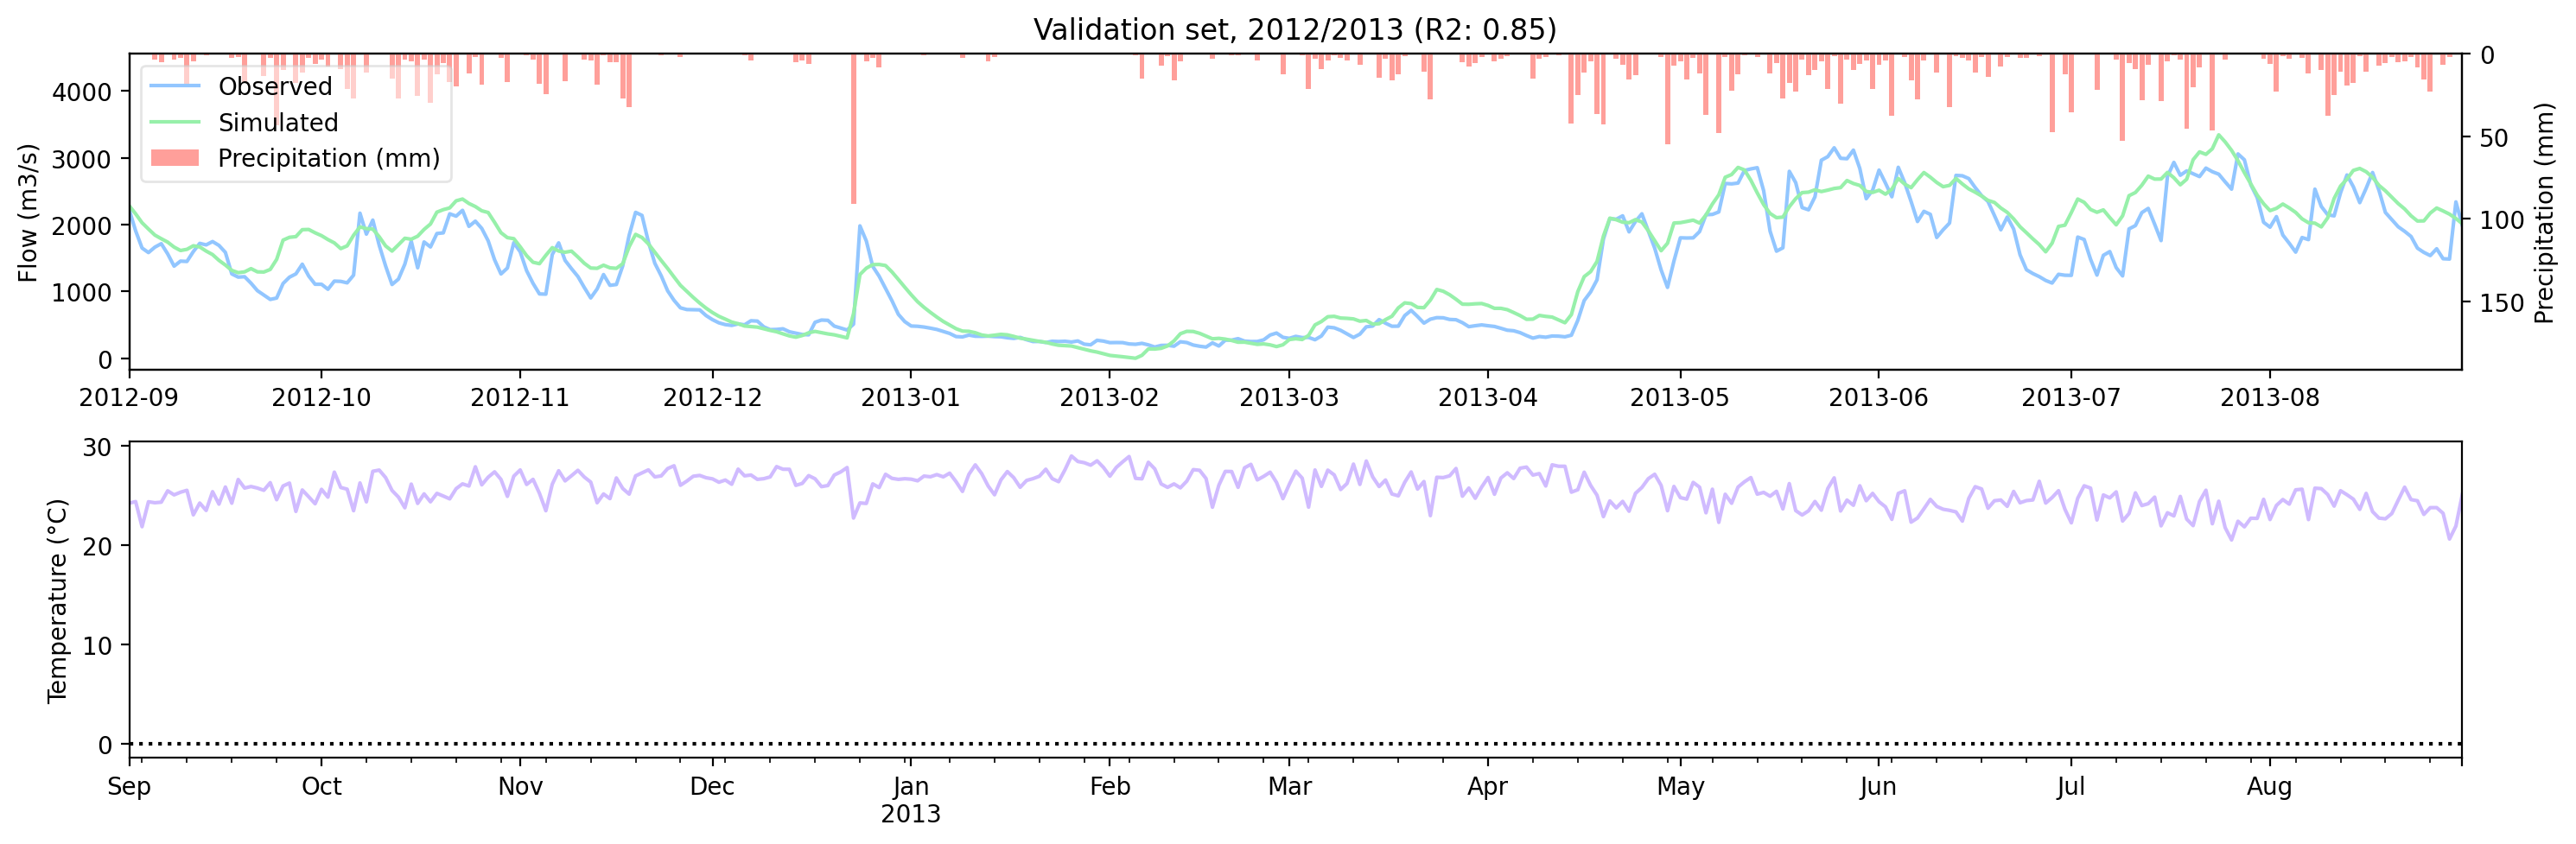

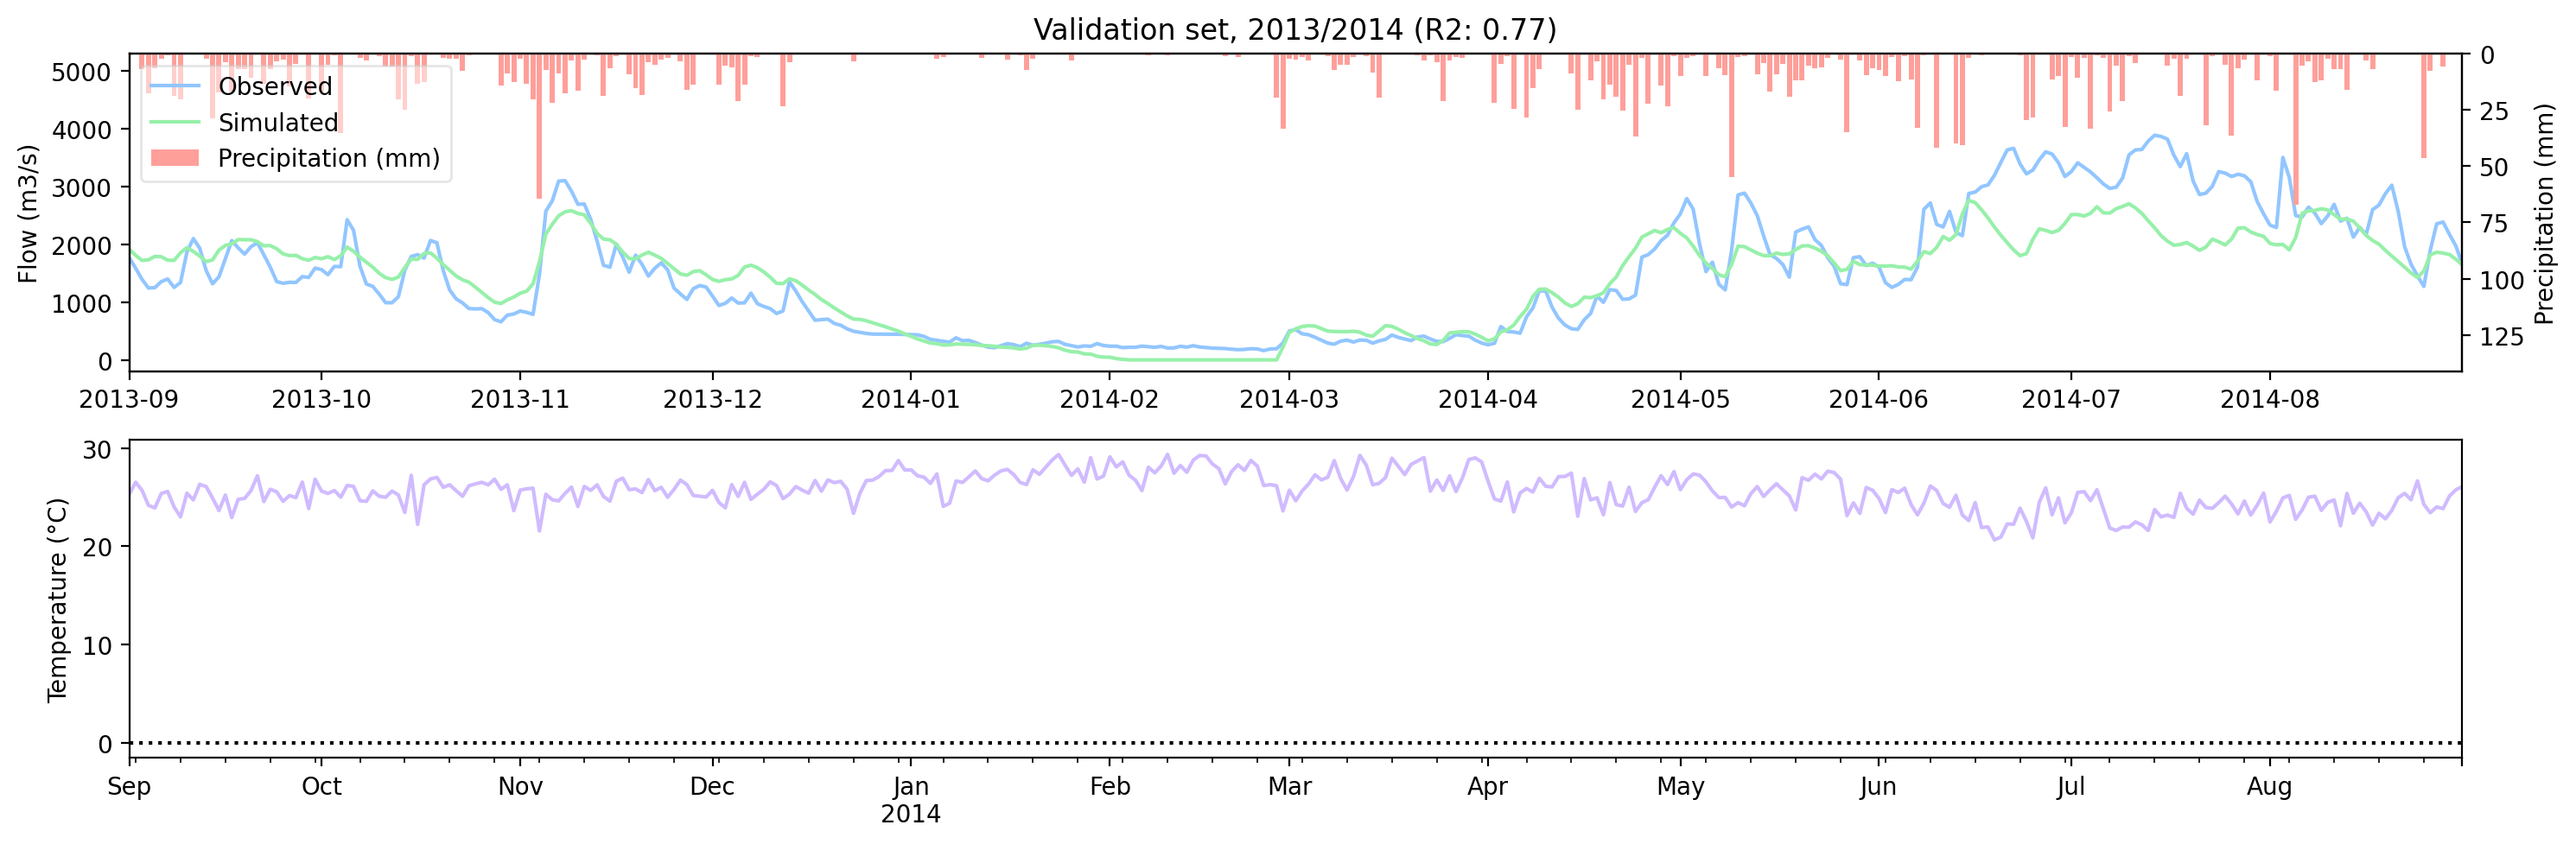

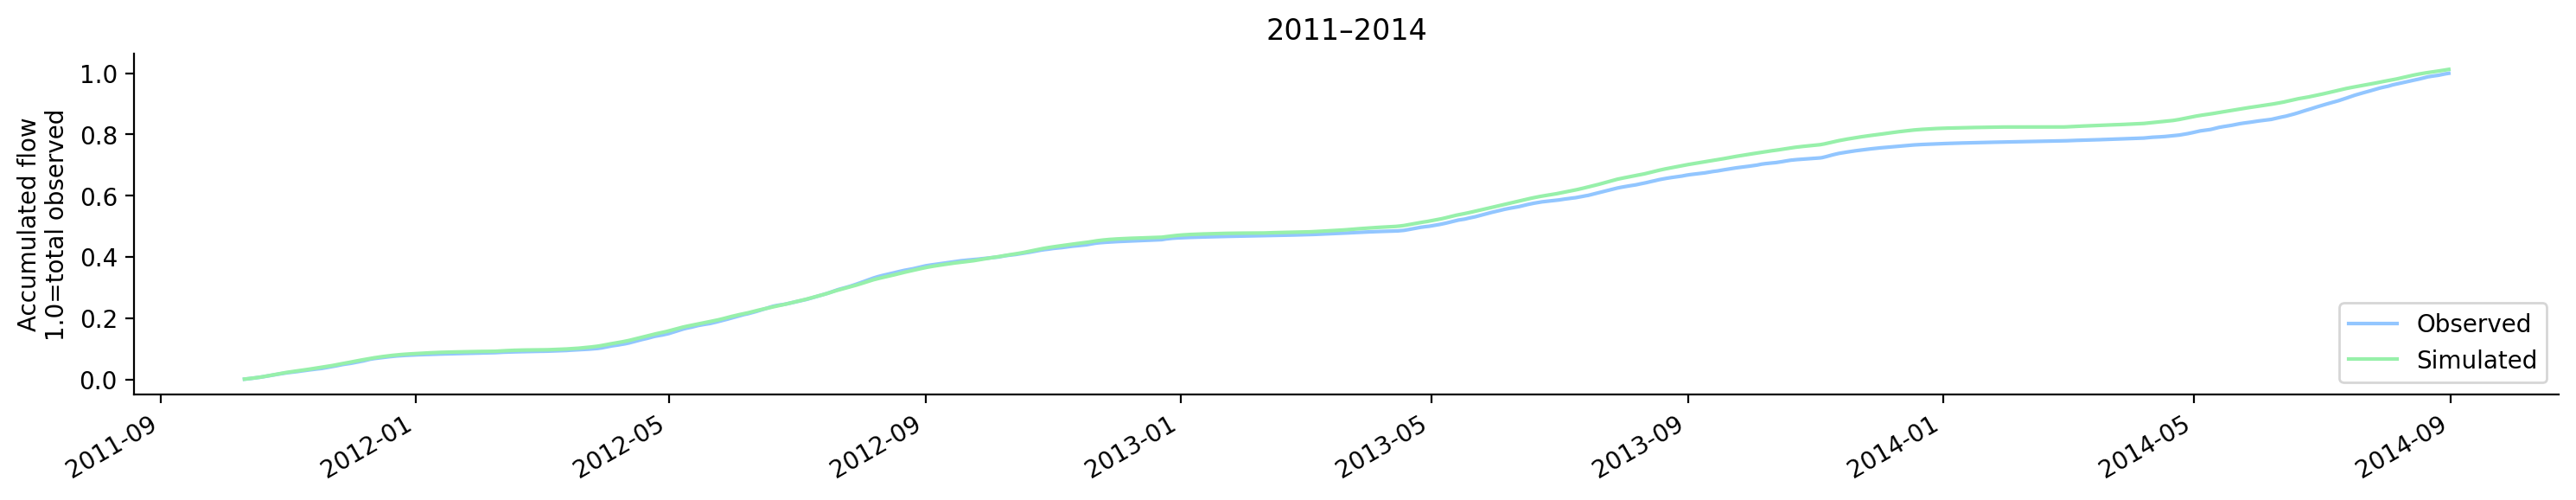

In [21]:
x = df_test[X_columns]
y = df_test[[Y_columns]]
x_norm = normalizeX(x)
y_norm = normalizeY(y)
y_hat_norm = predict(model, x_norm, y_norm, SEQUENCE_LENGTH, INPUT_d)
y_hat = denormalizeY(y_hat_norm)

init_timesteps=40
print("R2: %.2f of 1.0" % sklearn.metrics.r2_score(y.values[init_timesteps:], y_hat.values[init_timesteps:]))
print("MAE: %.2f m3/s" % sklearn.metrics.mean_absolute_error(y.values[init_timesteps:], y_hat.values[init_timesteps:]))

plot_data_with_temp_precip(x, y, y_hat, title="Validation set", init_timesteps=init_timesteps);
plt.savefig(f'./results/fig_0_validation_set.png', dpi=300, bbox_inches='tight')

for year in range(2011, 2014):
    s = df_test.hydrological_year_from == year
    if year==2011:
        init_timesteps=40
    else:
        init_timesteps=0
    plot_data_with_temp_precip(x[s], y[s], y_hat[s], title="Validation set", init_timesteps=init_timesteps);
    plt.savefig(f'./results/fig_validation_year_{year}.png', dpi=300, bbox_inches='tight')
    
init_timesteps=40
plot_accumulated(y[init_timesteps:], y_hat[init_timesteps:], title="%i–%i" % (2011, 2014));
plt.savefig('./results/fig_accumulated_validation.png', dpi=300, bbox_inches='tight')